## Run Seeded Campaigns

In [74]:
import random
import torch
import numpy as np
from tqdm.auto import trange

from botorch.models import SingleTaskGP, MixedSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf, optimize_acqf_mixed
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement, LogExpectedImprovement, ProbabilityOfImprovement
from botorch.test_functions import Hartmann

from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize

from utils import *
from categorical_hartmann import CategoricalHartmann

from matplotlib import pyplot as plt
plt.style.use('ggplot')

torch.set_default_dtype(torch.float64)

In [75]:
def random_sampler(n=2, levels=3, dims=3):
    """Randomly sample the design space."""
    set_seeds(120)
    cont = torch.rand(n, dims, dtype=torch.float64)
    cat = torch.randint(0, levels, (n, 1), dtype=torch.float64)
    # cat = torch.tensor(np.arange(0, 11, 1))[:,None]
    sample = torch.concat([cat, cont], dim=-1)
    return sample

In [84]:
seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)

n_initial = 5 # set number of initial points
budget = 50-n_initial
n_campaigns = 25 # set number of campaigns to run

collection_y = np.zeros((n_campaigns, n_initial+budget), dtype=float)
collection_X = np.zeros((n_campaigns, 7, n_initial+budget), dtype=float)
collection_acqf = np.zeros((n_campaigns, n_initial+budget), dtype=float)
collection_model_params = np.zeros((n_campaigns, 8, n_initial+budget), dtype=float)

# generate starting data values
CatHart = CategoricalHartmann(levels=3, dims=6, noise_std=0.0, seed=10)
print(CatHart)
X_ = random_sampler(n=n_initial, levels=3, dims=6)
y_ = CatHart(cat=X_[:,0].to(int), X=X_[:,1:])[:,None]

CategoricalHartmann
    Categories = 3
    Continuous Dims = 6
    LevelIntercepts = [1.0, 0.0, 1.5]
    LevelSlopes = [2.1052631578947367, 1.3947368421052633, 1.1578947368421053]
    Optimum: CAT 0 | 7.994458955851082


In [85]:
# iterate through each campaign (random seed)
for campaign in (pbar0 := trange(n_campaigns, leave=True, colour="red")):
    set_seeds(seeds[campaign]) # set the random seed for the campaign
    X = X_.clone() # create a copy of df
    y = y_.clone() # create a copy of df

    # iterate through each trial up to budget - n_initial
    for trial in (pbar1 := trange(budget, leave=True)):

        # build the gp model
        gp = MixedSingleTaskGP(
            train_X=X,
            train_Y=y,
            cat_dims=[0],
            input_transform = Normalize(d=X.shape[-1], indices=list(np.arange(0, 6, 1)+1)),
            outcome_transform = Standardize(m=y.shape[-1]),
        )

        # fit the model by maximizing the log marginal likelihood
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        mll = fit_gpytorch_model(mll)

        # collection_model_params[campaign,:,n_initial+trial] = torch.cat(
        #     [
        #         gp.covar_module.base_kernel.lengthscale[0],
        #         gp.covar_module.outputscale.view(1),
        #         gp.likelihood.noise
        #     ]
        # ).detach().numpy()

        bounds = torch.tensor([[0.0]*X.shape[-1], [1.0]*X.shape[-1]])

        bounds = torch.stack([torch.zeros(6+1), torch.ones(6+1)])
        bounds[0,0] = 0.0
        bounds[1,0] = float(3-1) # levels-1

        X_new, acq_value = optimize_acqf_mixed(
            # acq_function = UpperConfidenceBound(gp, beta=2),
            # acq_function = ExpectedImprovement(gp, best_f=y.max()),
            acq_function = LogExpectedImprovement(gp, best_f=y.max()),
            bounds=bounds,
            fixed_features_list=[{0:i} for i in range(3)],
            q=1,
            num_restarts=20,
            raw_samples=250,
        )

        collection_acqf[campaign, n_initial+trial] = acq_value.item()

        X = torch.cat([X, X_new])
        y = torch.cat([y, CatHart(cat=X_new[:,0].to(int), X=X_new[:,1:])[:,None]])

        pbar0.set_description(f"Processing Trial {trial+1} of Campaign {campaign+1}")
        pbar1.set_description(f"Campaign {campaign+1} | Best Value {round(torch.max(y).item(),3)}")

    collection_y[campaign,:] = y.flatten()
    collection_X[campaign, :, :] = X.T

np.save('runs_log/CategoricalHartmann6/LogEI/collection_y.npy', collection_y)
np.save('runs_log/CategoricalHartmann6/LogEI/collection_X.npy', collection_X)
np.save('runs_log/CategoricalHartmann6/LogEI/collection_acqf.npy', collection_acqf)
# np.save('runs_log/CategoricalHartmann6/UCB/collection_model_params.npy', collection_model_params)

Campaign 1 | Best Value 7.985: 100%|██████████| 45/45 [01:07<00:00,  1.49s/it]t/s]
Campaign 2 | Best Value 7.993: 100%|██████████| 45/45 [01:09<00:00,  1.54s/it], 67.03s/it]
Campaign 3 | Best Value 7.992: 100%|██████████| 45/45 [01:27<00:00,  1.95s/it], 68.29s/it]
Campaign 4 | Best Value 7.992: 100%|██████████| 45/45 [01:06<00:00,  1.48s/it], 77.15s/it]
Campaign 5 | Best Value 7.994: 100%|██████████| 45/45 [01:01<00:00,  1.37s/it], 73.01s/it]
Campaign 6 | Best Value 7.742: 100%|██████████| 45/45 [01:16<00:00,  1.69s/it], 68.92s/it]
Campaign 7 | Best Value 7.981: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s], 71.40s/it]
Campaign 8 | Best Value 7.884: 100%|██████████| 45/45 [01:06<00:00,  1.47s/it], 62.09s/it]
Campaign 9 | Best Value 7.988: 100%|██████████| 45/45 [00:43<00:00,  1.03it/s], 63.43s/it]
Campaign 10 | Best Value 7.973: 100%|██████████| 45/45 [01:20<00:00,  1.78s/it], 57.29s/it]
Campaign 11 | Best Value 7.969: 100%|██████████| 45/45 [01:52<00:00,  2.49s/it]4, 64.33s/it]
Camp

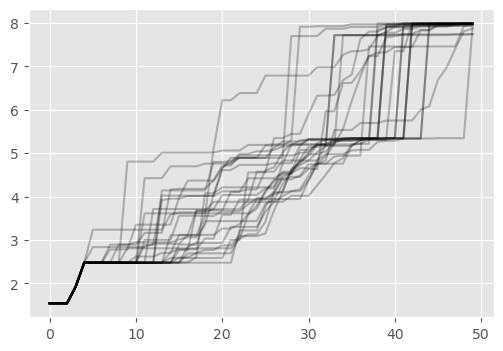

In [86]:
y = np.load('runs_log/CategoricalHartmann6/LogEI/collection_y.npy')

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.maximum.accumulate(y.T), color='black', alpha=0.25)
plt.show()

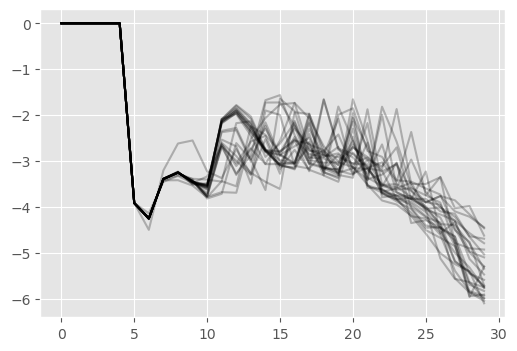

In [87]:
acq = np.load('runs_log/Hartmann6/LogEI/collection_acqf.npy')

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(acq.T, color='black', alpha=0.25)
plt.show()
